
# ensembling classifiers internally using sampling

##### Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>

part of script below was cited from:
ref. https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py


In [1]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

import itertools
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier

from imblearn.metrics import geometric_mean_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

C:\ProgramData\Anaconda3\Lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\Lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\ProgramData\Anaconda3\Lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
from helper import *

In [3]:
def evaluate_trained_model(lr, X_train, y_train, X_test, y_test):
    print('clf report for the testing set:')
    print(classification_report(y_test, lr.predict(X_test)))
    print('the roc_auc score is:{:0.2f}'.format(roc_auc_score(y_test, lr.predict(X_test))))
    
    print('clf report for the training set:')
    print(classification_report(y_train, lr.predict(X_train)))
    print('the roc_auc score is:{:0.2f}'.format(roc_auc_score(y_train, lr.predict(X_train))))

# Load the data set


In [4]:
data = pd.read_pickle("mailout_train_cleaned.pkl")
# data = data.drop_duplicates(subset= data.columns[:-1:])
data.drop_duplicates(inplace=True)

In [5]:
X = data.iloc[:, 0:-1:]
y = data.iloc[:, -1]

In [6]:
# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [7]:
for col in X.columns:
    if any(isinstance(y,(str)) for y in X[col].unique()):  
        print('{:}, {:}'.format( col , X[col].unique()))

In [8]:
def train_clf(model, model_name, ax, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    model.fit(X_train, y_train)
    y_pred_model = model.predict(X_test)
    ra_score = roc_auc_score( y_test, y_pred_model)
    print('{:} ROC AUC accuracy: {:.2f}:'.format(model_name, roc_auc_score( y_test, y_pred_model)))

    cm_model = confusion_matrix(y_test, y_pred_model)
    
    if ax is not None:
        plot_confusion_matrix(cm_model, classes= [0,1], ax=ax,
                          title= '{:}'.format(model_name))
    
    return cm_model, ra_score

In [9]:
n_e = 50 
seed = 0

base_estimator = AdaBoostClassifier(n_estimators=10)
models = dict({
#     "DecisionTree": DecisionTreeClassifier(),
#     "Bagging": BaggingClassifier(n_estimators=n_e, random_state=seed, n_jobs=-1),
    "BalancedBagging": BalancedBaggingClassifier(n_estimators=n_e, random_state=seed,n_jobs=-1),
#     "RandomForest":RandomForestClassifier(n_estimators=n_e, random_state=seed, n_jobs=-1),
    "BalancedRandomForest": BalancedRandomForestClassifier(n_estimators=n_e, random_state=seed, n_jobs=-1),
#     "AdaBoost": AdaBoostClassifier(n_estimators=10),
    "EasyEnsemble":EasyEnsembleClassifier(n_estimators=10,base_estimator=base_estimator,n_jobs=-1),
    "RUSBoost":RUSBoostClassifier(n_estimators=10,base_estimator=base_estimator),
#     "XGB":XGBClassifier()
    })

BalancedBagging ROC AUC accuracy: 0.77:
BalancedRandomForest ROC AUC accuracy: 0.74:
EasyEnsemble ROC AUC accuracy: 0.78:
RUSBoost ROC AUC accuracy: 0.78:


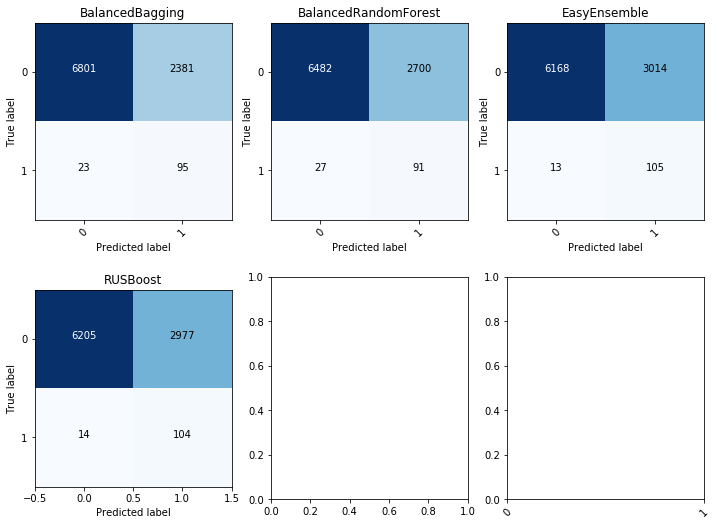

In [10]:
fig, ax = plt.subplots(int(np.ceil(len(models)/3)), 3, figsize=(12,9))

for idx, item in enumerate(models.items()):
    train_clf(model=item[1], model_name=item[0], ax=ax[idx//3, idx%3])

# use the subset to retrain the model

In [11]:
features_importance = pd.DataFrame(item[1].feature_importances_, columns=['importance'])

In [12]:
features_importance['feature_names']=X.columns

In [13]:
features_importance_sorted = features_importance.sort_values(by = ['importance'], ascending=False)

In [14]:
base_estimator = AdaBoostClassifier(n_estimators=10)
model = EasyEnsembleClassifier(n_estimators=10, base_estimator=base_estimator,n_jobs=-1)

In [15]:
scores = []
feature_counts = np.arange(3, 50, 5)
feature_counts = np.append(feature_counts, len(features_importance))
cms = []

for feature_count in feature_counts:
    subset_features = features_importance_sorted.iloc[:feature_count]['feature_names']
    X_train_sub, X_test_sub = X_train[subset_features], X_test[subset_features]
    cm, score = train_clf(model, 'clf with {:} features'.format(feature_count), ax = None , X_train = X_train_sub, y_train = y_train, X_test = X_test_sub, y_test = y_test)
    scores.append(score)
    cms.append(cm)

clf with 3 features ROC AUC accuracy: 0.78:
clf with 8 features ROC AUC accuracy: 0.78:
clf with 13 features ROC AUC accuracy: 0.78:
clf with 18 features ROC AUC accuracy: 0.78:
clf with 23 features ROC AUC accuracy: 0.78:
clf with 28 features ROC AUC accuracy: 0.78:
clf with 33 features ROC AUC accuracy: 0.78:
clf with 38 features ROC AUC accuracy: 0.78:
clf with 43 features ROC AUC accuracy: 0.78:
clf with 48 features ROC AUC accuracy: 0.78:
clf with 1151 features ROC AUC accuracy: 0.78:


In [16]:
most_relavent_features = feature_counts[np.argmax(scores)]
subset_features = features_importance_sorted.iloc[:most_relavent_features]['feature_names']

In [17]:
features_importance_sorted.head(10)

,importance,feature_names
918,0.10,D19_SOZIALES_1.0
11,0.04,GEBURTSJAHR
382,0.04,D19_LETZTER_KAUF_BRANCHE_26.0
9,0.03,EINGEZOGENAM_HH_JAHR
952,0.03,FINANZ_SPARER
1015,0.03,KBA05_ZUL4
971,0.02,KBA05_DIESEL
975,0.02,KBA05_HERST2
1094,0.02,KBA13_KW_90
12,0.02,KBA13_ANZAHL_PKW


# fine tune the model using grid_search_cv

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV 

In [19]:
base_estimator = AdaBoostClassifier()
clf = EasyEnsembleClassifier(base_estimator=base_estimator)

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state= 42) 
param_grid = [{'base_estimator__n_estimators':[30], 
               "base_estimator": [EasyEnsembleClassifier(),
                                  RUSBoostClassifier(),
                                  BalancedBaggingClassifier()
                                 ],
               'n_estimators':[10, 30, 50], 
               'warm_start':[False]
              }]
score = 'roc_auc'
grid = GridSearchCV( clf, param_grid, scoring= score, n_jobs= 6, verbose=1, cv = cv)

grid.fit(X[subset_features], y)

grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed: 10.3min finished


0.7926607733289688

In [20]:
# grid.get_params()

In [21]:
grid.best_params_

{'base_estimator': RUSBoostClassifier(n_estimators=30),
 'base_estimator__n_estimators': 30,
 'n_estimators': 50,
 'warm_start': False}

In [22]:
grid.cv_results_['mean_test_score']

array([0.78342612, 0.78847662, 0.78964111, 0.79199267, 0.79167427,
       0.79266077, 0.77183993, 0.77326049, 0.77438792])

In [23]:
grid.best_score_

0.7926607733289688

# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [24]:
mail_out_test = pd.read_pickle("mailout_test_cleaned.pkl")
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
subset_features

918                  D19_SOZIALES_1.0
11                        GEBURTSJAHR
382     D19_LETZTER_KAUF_BRANCHE_26.0
9                EINGEZOGENAM_HH_JAHR
952                     FINANZ_SPARER
1015                       KBA05_ZUL4
971                      KBA05_DIESEL
975                      KBA05_HERST2
1094                      KBA13_KW_90
12                   KBA13_ANZAHL_PKW
966                    KBA05_AUTOQUOT
961                      KBA05_ANHANG
994                        KBA05_MOD3
1065             KBA13_HERST_BMW_BENZ
978                      KBA05_HERST5
1060                  KBA13_HALTER_60
906                      WOHNLAGE_3.0
1070                  KBA13_KMH_0_140
1071                    KBA13_KMH_110
392        D19_NAHRUNGSERGAENZUNG_0.0
905                      WOHNLAGE_2.0
1150                   W_KEIT_KIND_HH
1075                    KBA13_KMH_210
791         PRAEGENDE_JUGENDJAHRE_1.0
1053                  KBA13_HALTER_25
271                  D19_BIO_OEKO_0.0
797         

In [25]:
pre_dictions = grid.predict(mail_out_test[subset_features])

In [26]:
test_prob = grid.predict_proba(mail_out_test[subset_features])

In [27]:
mailout_test['RESPONSE'] = test_prob[:,1:2]

In [28]:
to_submission = mailout_test[['LNR', "RESPONSE"]]

In [30]:
to_submission.to_csv('thrid_trial.csv', index=None)